In [1]:
import pyfftw
import numpy as np
import pylangevin
import matplotlib.pyplot as plt
import sys, datetime
import datetime, pickle, tempfile, time, sys
import modemc
from helpers.sim_helper import *
from helpers import plotting
from IPython.display import clear_output

In [2]:
use_temp_folder = True
run_name = "test"
ssh_comp = "notebook"
simulation_name = "langevin_switch"

In [3]:
def Upot(x, y):
    r2 = x**2 + y**2
    r = np.sqrt(r2)
    return (1/2)*(r - 1)**2*(3*U0*r2*(xip + 2 + xim*y/r) - 2*U0*(r - 1)*(3*r + 1))

In [4]:
def run_simulation(Tf, U0, xi1, xi2, beta, gamma, dt, xT_err, max_N_sims, N_tpe):
    N_steps = int(np.round(Tf/dt))

    x0 = np.array([-1, 0])

    xT_err = 0.1
    xT_min = np.array([1, 0]) - xT_err
    xT_max = np.array([1, 0]) + xT_err

    parameters = {
        'N_steps' : N_steps,
        'dt' : dt,
        'beta' : beta,
        'gamma' : gamma,
        #'seed' : 1,

        'U0' : U0,
        'xi1' : xi1,
        'xi2' : xi2
    }

    simulator = pylangevin.systems.Switch(parameters)
    tpe = []
    tpe_count = 0

    for i in range(max_N_sims):

        if i % 100 == 0:
            print('%s%%\t%s/%s\tTPE=%s' % ( 100*np.round(tpe_count/N_tpe,2), i+1, max_N_sims, tpe_count), end='\r')

        path = simulator.simulate(x0)
        x, y = path[:,0], path[:,1]

        if x[-1] > xT_min[0] and x[-1] < xT_max[0] and y[-1] > xT_min[1] and y[-1] < xT_max[1]:
            tpe.append(path)
            tpe_count += 1
            print('%s%%\t%s/%s\tTPE=%s' % ( 100*np.round(tpe_count/N_tpe,2), i+1, max_N_sims, tpe_count), end='\r')
            
            if tpe_count == N_tpe:
                sim_result.save_data({ 'tpe' : tpe }, sample_ratio=1)
                break
                
        if tpe_count % N_save == 0:
            sim_result.save_data({ 'tpe' : tpe }, sample_ratio=1)
            tpe = []

In [5]:
Tf = 50
dt = 1e-1
beta = 10
gamma = 5

In [6]:
max_N_sims = int(1e6)
N_tpe = 1000
N_save = 100
RMS_window = 50

In [7]:
U0 = 3
xi1 = 0
xi2 = 2
xip = xi2 + xi1
xim = xi2 - xi1

In [8]:
xT_err = 0.2

In [9]:
# Load arguments if running as a script
if sys.argv[1] == "args":
    use_temp_folder = False
    params_pkl_path = sys.argv[2]
    params = pickle.load(open(params_pkl_path, 'rb'))

    for param_k, param_v in params.items():
        globals()[param_k] = param_v

In [10]:
parameters_to_include_in_name = {
    'beta' : beta,
    'dt' : dt,
    'Tf' : Tf,
    'N_tpe' : N_tpe
}
save_params = {
    'beta' : beta,
    'dt' : dt,
    'Tf' : Tf,
    'N_tpe' : N_tpe,
    
    'gamma' : gamma,
    'max_N_sims' : max_N_sims,
    'N_tpe' : N_tpe,
    'U0' : U0,
    'xi1' : xi1,
    'xi2' : xi2,
    'xT_err' : xT_err,
}

In [11]:
sim_result = SimResult(simulation_name, run_name, parameters_to_include_in_name, use_temp_folder, ssh_comp)
sim_result.save_note('UNFINISHED', str(datetime.datetime.now()))
sys.excepthook = sim_result.crash_log

if sys.argv[1] == "args":
    sim_result.save_pkl('args_params', args_params)

Result name: [test] langevin_switch, beta=10, dt=1.00e-01, Tf=50, N_tpe=1000 (21-10-23, 23:41:13)

In progress folder:
/tmp/tmp0vekzo2x/langevin_switch/[test] langevin_switch, beta=10, dt=1.00e-01, Tf=50, N_tpe=1000 (21-10-23, 23:41:13)

Output folder:
/tmp/tmp0vekzo2x/langevin_switch/[test] langevin_switch, beta=10, dt=1.00e-01, Tf=50, N_tpe=1000 (21-10-23, 23:41:13)



In [12]:
run_simulation(Tf, U0, xi1, xi2, beta, gamma, dt, xT_err, max_N_sims, N_tpe)

In [13]:
tpe = sim_result.load_random_sample(1.0, 'tpe')

In [14]:
mean_path_x = np.sum(tpe[:, :, 0], axis=0) / tpe.shape[0]
mean_path_y = np.sum(tpe[:, :, 1], axis=0) / tpe.shape[0]
mean_path = np.array([mean_path_x, mean_path_y]).T

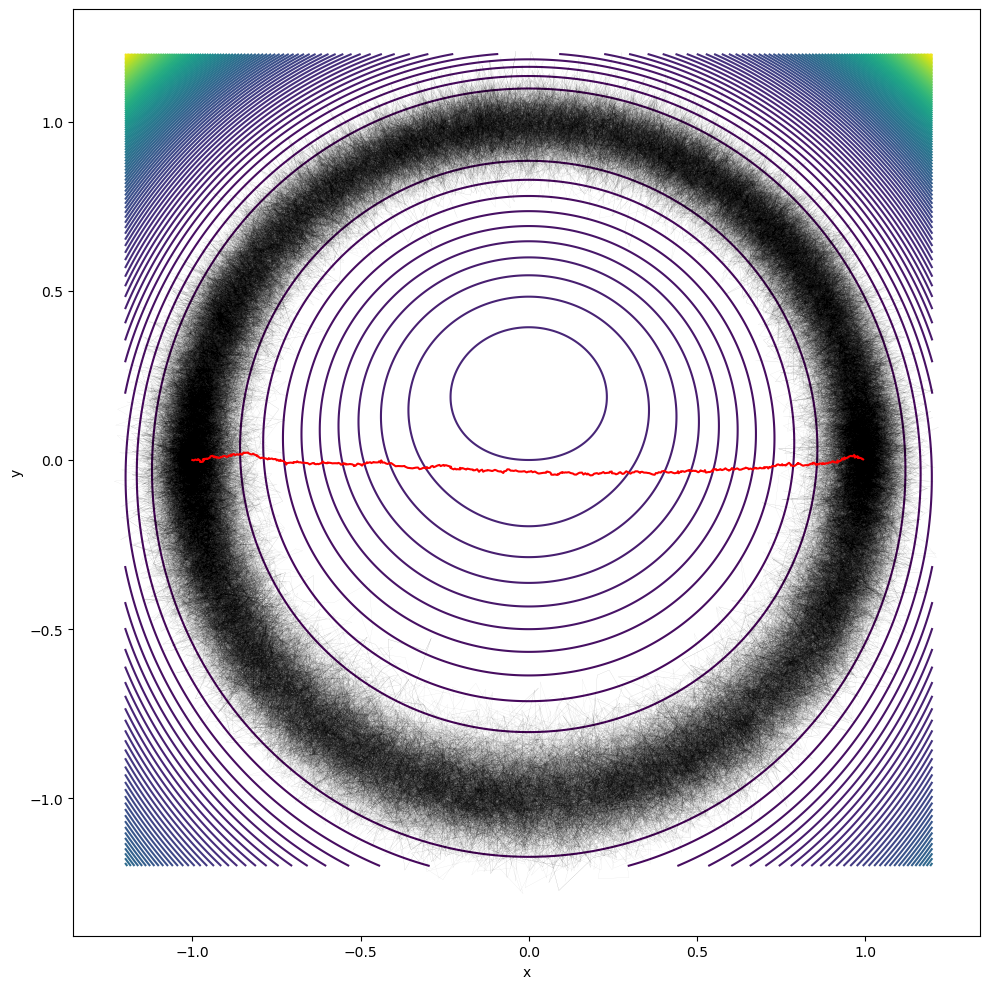

Saving figure trajectories


In [15]:
plot_choices = np.random.choice(len(tpe), min(len(tpe), 500))
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
xlims = [-1.2, 1.2]
ylims = [-1.2, 1.2]
x = np.linspace(xlims[0], xlims[1], 400)
y = np.linspace(ylims[0], ylims[1], 400)
X, Y = np.meshgrid(x,  y)
Z = Upot(X, Y)
ax.contour(X, Y, Z, levels=100)
ax.set_xlabel('x')
ax.set_ylabel('y')
for path in tpe[plot_choices]:
    x, y = path[:,0], path[:,1]
    ax.plot(x, y, lw=0.1, alpha=0.2, color='black')
ax.plot(mean_path_x, mean_path_y, color='red')
plt.tight_layout()
plt.show()
sim_result.save_figure(fig, 'trajectories')

In [16]:
path_ratios = np.count_nonzero(tpe[:,:,1] > 0, axis=1) / tpe.shape[1]
pU = np.mean(path_ratios)
std_pU = np.std(path_ratios)

In [17]:
pU2 = np.count_nonzero((np.count_nonzero(tpe[:,:,1] > 0, axis=1) / tpe.shape[1]) > 0.5) / tpe.shape[0]

In [18]:
def rms(arr):
    arr = np.array(arr)
    return np.sqrt(np.mean( (arr - np.mean(arr))**2 ))
def ame(arr):
    arr = np.array(arr)
    return np.mean( np.abs(arr - np.mean(arr)) )
intermediate_pUs = []
intermediate_pU2s = []
intermediate_pUs_RMS = []
intermediate_pU2s_RMS = []
intermediate_pUs_AME = []
intermediate_pU2s_AME = []
for i in range(1, tpe.shape[0]):
    path_ratios = np.count_nonzero(tpe[:i,:,1] > 0, axis=1) / tpe.shape[1]
    pU = np.mean(path_ratios)
    std_pU = np.std(path_ratios)
    
    pU2 = np.count_nonzero((np.count_nonzero(tpe[:i,:,1] > 0, axis=1) / tpe.shape[1]) > 0.5) / (i+1)
    
    intermediate_pUs.append(pU)
    intermediate_pU2s.append(pU2)
    
    #intermediate_pUs_RMS.append( np.sqrt(np.sum((np.array(intermediate_pUs) - np.mean(intermediate_pUs))**2) / i) )
    #intermediate_pU2s_RMS.append( np.sqrt(np.sum((np.array(intermediate_pU2s) - np.mean(intermediate_pU2s))**2) / i) )
intermediate_pUs = np.array(intermediate_pUs)
intermediate_pU2s = np.array(intermediate_pU2s)
for i in range(RMS_window, tpe.shape[0]-1):
    intermediate_pUs_RMS.append( rms(intermediate_pUs[i-RMS_window:i]) )
    intermediate_pU2s_RMS.append( rms(intermediate_pU2s[i-RMS_window:i]) )
    intermediate_pUs_AME.append( rms(intermediate_pUs[i-RMS_window:i]) )
    intermediate_pU2s_AME.append( rms(intermediate_pU2s[i-RMS_window:i]) )

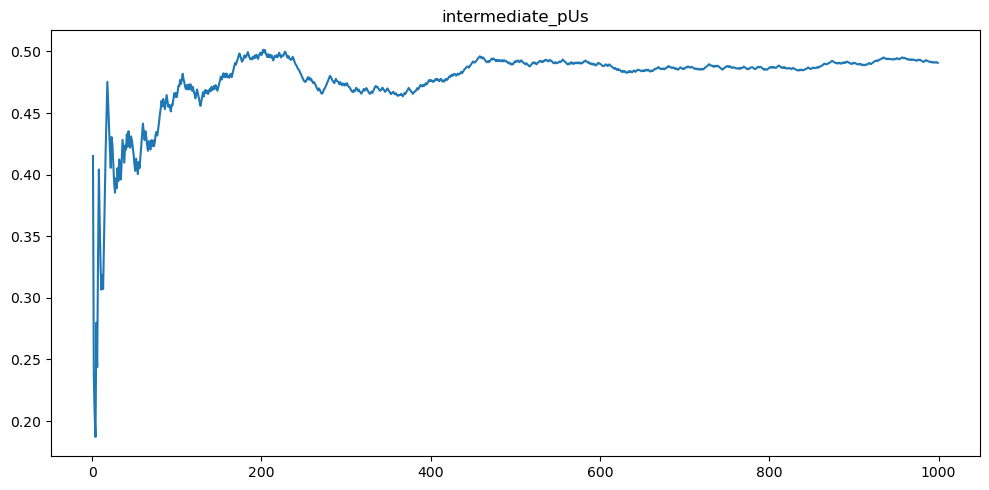

Saving figure intermediate_pUs


In [19]:
plot_choices = np.random.choice(len(tpe), min(len(tpe), 500))
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.plot(range(1, tpe.shape[0]), intermediate_pUs)
ax.set_title('intermediate_pUs')
plt.tight_layout()
plt.show()
sim_result.save_figure(fig, 'intermediate_pUs')

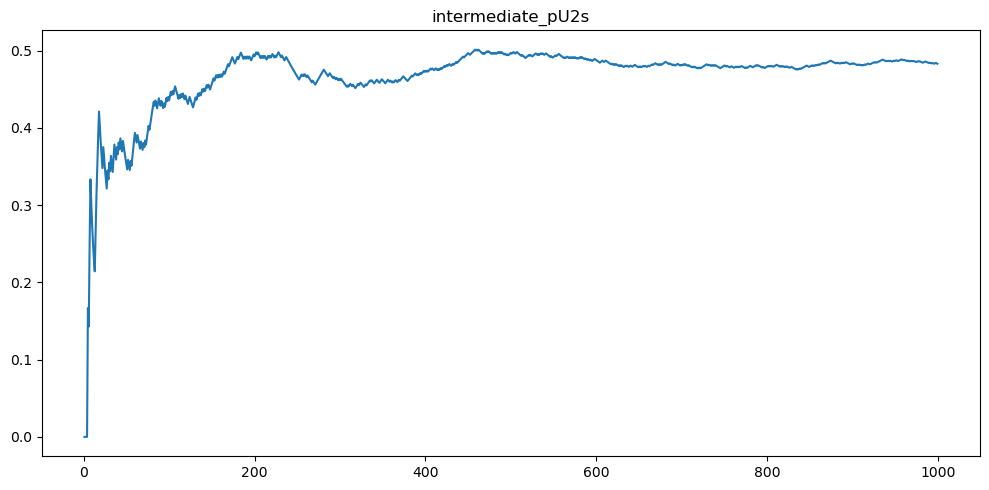

Saving figure intermediate_pU2s


In [20]:
plot_choices = np.random.choice(len(tpe), min(len(tpe), 500))
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.plot(range(1, tpe.shape[0]), intermediate_pU2s)
ax.set_title('intermediate_pU2s')
plt.tight_layout()
plt.show()
sim_result.save_figure(fig, 'intermediate_pU2s')

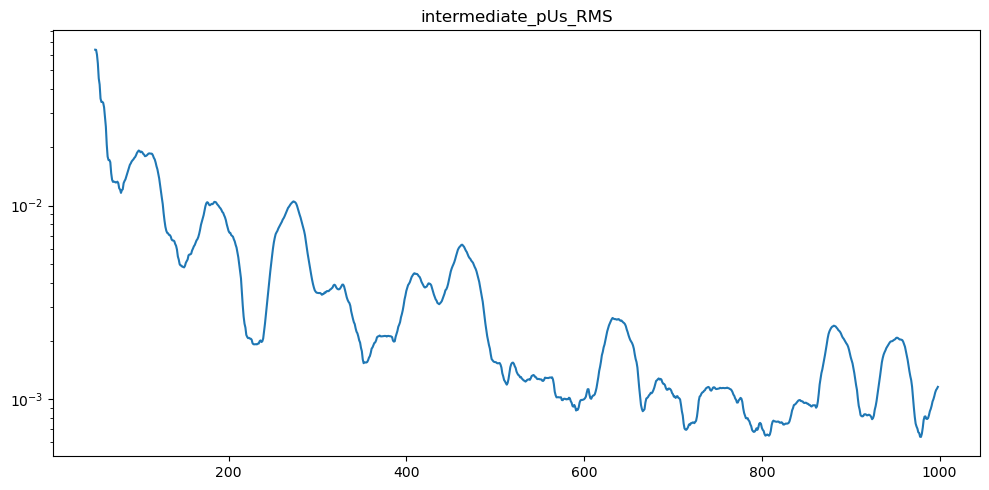

Saving figure intermediate_pUs_RMS


In [21]:
plot_choices = np.random.choice(len(tpe), min(len(tpe), 500))
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.plot(range(RMS_window, tpe.shape[0]-1), intermediate_pUs_RMS)
ax.set_title('intermediate_pUs_RMS')
ax.set_yscale('log')
plt.tight_layout()
plt.show()
sim_result.save_figure(fig, 'intermediate_pUs_RMS')

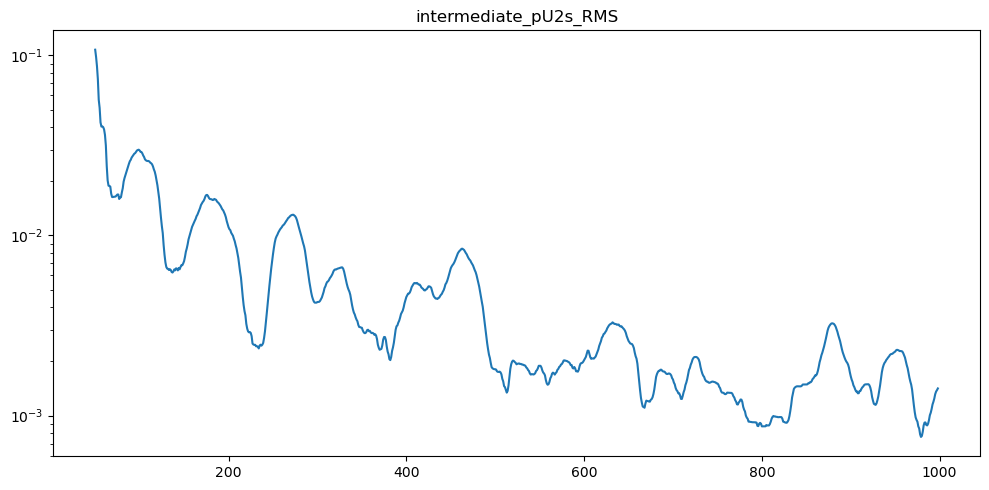

Saving figure intermediate_pU2s_RMS


In [22]:
plot_choices = np.random.choice(len(tpe), min(len(tpe), 500))
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.plot(range(RMS_window, tpe.shape[0]-1), intermediate_pU2s_RMS)
ax.set_title('intermediate_pU2s_RMS')
ax.set_yscale('log')
plt.tight_layout()
plt.show()
sim_result.save_figure(fig, 'intermediate_pU2s_RMS')

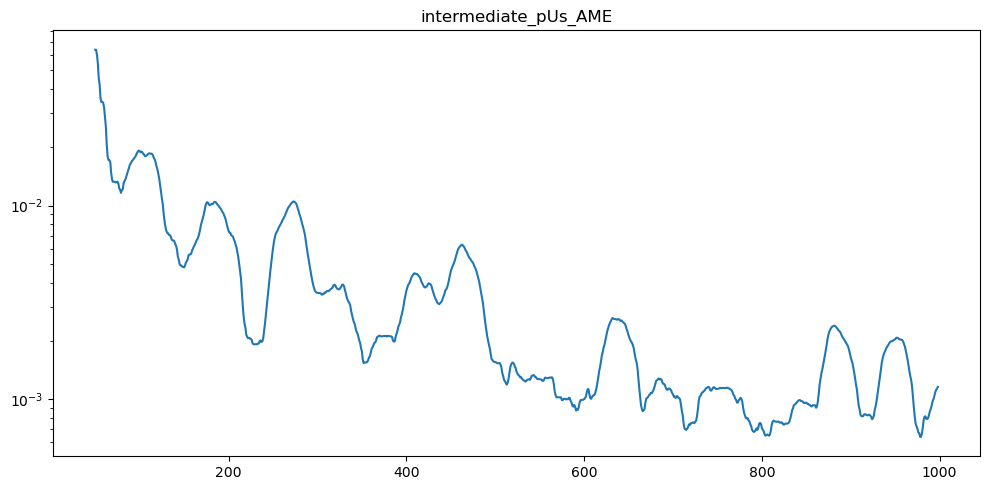

Saving figure intermediate_pUs_AME


In [23]:
plot_choices = np.random.choice(len(tpe), min(len(tpe), 500))
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.plot(range(RMS_window, tpe.shape[0]-1), intermediate_pUs_AME)
ax.set_title('intermediate_pUs_AME')
ax.set_yscale('log')
plt.tight_layout()
plt.show()
sim_result.save_figure(fig, 'intermediate_pUs_AME')

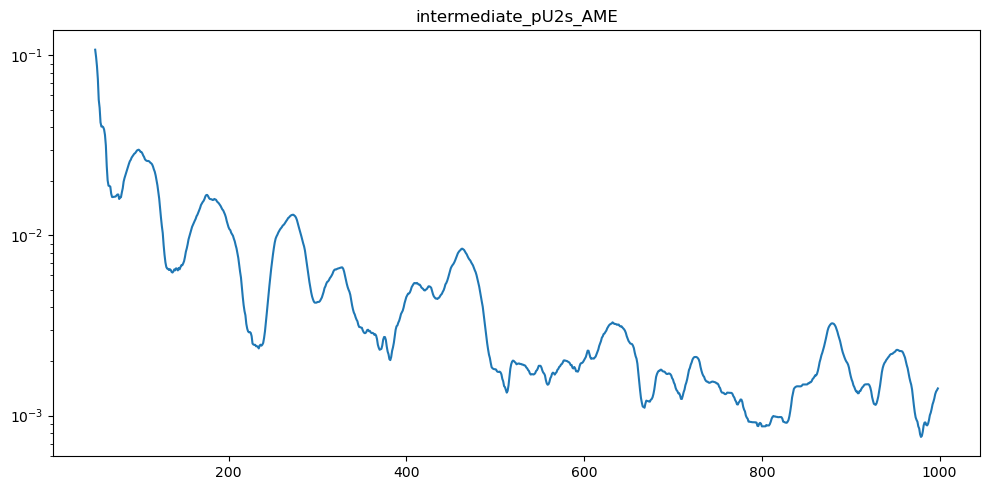

Saving figure intermediate_pU2s_AME


In [24]:
plot_choices = np.random.choice(len(tpe), min(len(tpe), 500))
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.plot(range(RMS_window, tpe.shape[0]-1), intermediate_pU2s_AME)
ax.set_title('intermediate_pU2s_AME')
ax.set_yscale('log')
plt.tight_layout()
plt.show()
sim_result.save_figure(fig, 'intermediate_pU2s_AME')

In [25]:
calcs = {
    'pU' : pU,
    'std_pU' : std_pU,
    'pU2' : pU2,
    'mean_path' : mean_path,
    'path_ratios' : path_ratios,
    'intermediate_pUs' : intermediate_pUs,
    'intermediate_pU2s' : intermediate_pU2s,
    'intermediate_pUs_RMS' : intermediate_pUs_RMS,
    'intermediate_pU2s_RMS' : intermediate_pU2s_RMS,
    'intermediate_pUs_AME' : intermediate_pUs_AME,
    'intermediate_pU2s_AME' : intermediate_pU2s_AME,
    'final_pU_RMS' : intermediate_pUs_RMS[-1],
    'final_pU2_RMS' : intermediate_pU2s_RMS[-1],
    'final_pU_AME' : intermediate_pUs_AME[-1],
    'final_pU2_AME' : intermediate_pU2s_AME[-1],
}

In [26]:
transition_notes = ""
transition_notes += 'pU: %s\n' % pU
transition_notes += 'std_pU: %s\n' % std_pU
sim_result.save_note('transition_notes', transition_notes)
sim_result.log(transition_notes)

pU: 0.49075023126919337
std_pU: 0.3843736248037087



In [27]:
sim_result.save_np_array('tpe', tpe)

In [28]:
sim_result.save_pkl('params', save_params)
sim_result.save_pkl('calcs', calcs)
sim_result.move_from_progress_to_output()

In [29]:
sim_result.remove_note('UNFINISHED')
sim_result.save_note('DONE', str(datetime.datetime.now()))
sim_result.remove_status_file()